In [2]:
%load_ext autoreload
%autoreload 2
import litebird_sim as lbs
import numpy as np
import healpy as hp
import sbm
import logging
import toml
from pathlib import Path
import matplotlib.pyplot as plt

# from rich import print
logging.basicConfig(level=logging.WARNING)

# Load your Imo in litebird_sim

CONFIG_PATH = Path.home() / ".config" / "litebird_imo"
CONFIG_FILE_PATH = CONFIG_PATH / "imo.toml"
tomlinfo = toml.load(CONFIG_FILE_PATH)
flatfile_location = tomlinfo["repositories"][0]["location"]

imo_version = "v2"
imo = lbs.Imo(flatfile_location=flatfile_location)

In [3]:
fg_models = ["pysm_dust_0", "pysm_synch_0"]
sim = lbs.Simulation(random_seed=None)
mdim = 2
cmap = sbm.get_cmap()
# sim_channels = sbm.channel_list[:2] # Only two channels

sim_channels = sbm.channel_list
np.random.seed(123)

gamma_T_list = [1.019031716035418, 1.0426732981603957]  # [dust, synch] for top
gamma_B_list = [1.0130868422025714, 1.048540936388469]  # [dust, synch] for bottom

channel = "M1-140"
detector_name = "001_003_030_00A_" + channel[3:] + "_T"
telescope = channel[0] + "FT"
print(f"Running channel: {channel}")

sf = sbm.ScanFields.load_det(f"{channel}/{detector_name}")

Mbsparams = lbs.MbsParameters(
    make_cmb=False,
    cmb_r=0.0,
    make_fg=True,
    seed_cmb=1234,
    fg_models=fg_models,
    gaussian_smooth=False,
    bandpass_int=False,
    nside=sf.nside,
    units="K_CMB",
    maps_in_ecliptic=False,
)
ch_info = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
    imo=imo,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info,
)
map_info = mbs.run_all()[0]
fgs = mbs.generate_fg()[0]
dust = fgs[fg_models[0]][0][0]
synch = fgs[fg_models[1]][0][0]
components = [dust, synch]

temp = map_info[channel][0]
pol = map_info[channel][1] + 1j * map_info[channel][2]

signal_field = sbm.SignalFields.bandpass_mismatch_field(
    sf,
    mdim,
    pol,
    gamma_T_list,
    gamma_B_list,
    components,
)
output_map = sf.map_make(signal_field, show_eq=False)
residual = output_map - map_info[channel]
residual *= 1e6

Running channel: M1-140


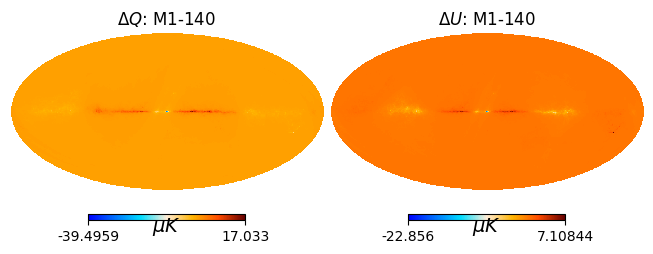

In [4]:
hp.mollview(
    residual[1],
    title=f"$\Delta Q$: {channel}",
    cmap=cmap,
    sub=(1, 2, 1),
    unit="$\mu K$",
)
hp.mollview(
    residual[2],
    title=f"$\Delta U$: {channel}",
    cmap=cmap,
    sub=(1, 2, 2),
    unit="$\mu K$",
)

In [5]:
syst = sbm.Systematics()
freq_maps = []

for channel in sbm.channel_list:
    config = sbm.Configlation(imo, channel)
    config.mdim = 2
    config.parallel = True
    config.nside = sf.nside
    config.xlink_threshold = 0.7  # avoid mapmake in singular pixels
    config.use_hwp = False

    # Define the telescope
    telescope = channel[0] + "FT"

    # Load the channel info
    ch_info = lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
    detectors = ch_info.detector_names

    gamma_T = np.random.normal(
        loc=1.0, scale=0.01, size=[len(detectors), len(fg_models)]
    )
    gamma_B = np.random.normal(
        loc=1.0, scale=0.01, size=[len(detectors), len(fg_models)]
    )

    syst.set_bandpass_mismatch(detectors, gamma_T, gamma_B, components)

    output, inputmap = sbm.sim_bandpass_mismatch(
        config,
        syst,
        Mbsparams,
    )
    freq_maps.append(output)
freq_maps = np.array(freq_maps) * 1e6

Processing H3-402: 100%|██████████| 338/338 [00:06<00:00, 52.32it/s] 


In [6]:
from fgbuster import (
    CMB,
    Dust,
    Synchrotron,
    basic_comp_sep,
)

components = [CMB(), Dust(150.0), Synchrotron(20.0)]
cmb = sbm.generate_cmb(sf.nside, r=0, cmb_seed=12345)

cmb_fg = cmb + freq_maps
#hp.mollview(cmb_fg[0][1], title="CMB + FG", cmap=cmap, unit="$\mu K$")

In [7]:
mask = hp.read_map(
    "/group/cmb/litebird/usr/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=[3]
)
mask = hp.ud_grade(mask, 256)
mask = hp.ud_grade(mask, 128)
#hp.mollview(mask)

In [8]:
components = [CMB(), Dust(150.0), Synchrotron(20.0)]
instrument = sbm.get_instrument_table(imo)
m = cmb_fg[:, 1:, :] * mask
m[m == 0] = hp.UNSEEN
result = basic_comp_sep(components, instrument, m)

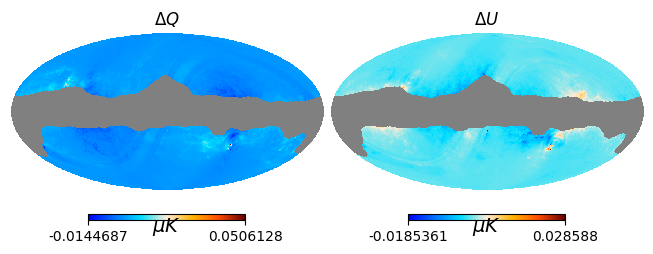

In [9]:
result_cmb = np.array([np.zeros(len(result.s[0][0])), result.s[0][0], result.s[0][1]])
compsep_res = (cmb - result_cmb) * mask
compsep_res[compsep_res == 0] = hp.UNSEEN

cl_res = hp.anafast(compsep_res)
hp.mollview(compsep_res[1], title="$\Delta Q$", cmap=cmap, unit="$\mu K$", sub=(1, 2, 1))
hp.mollview(compsep_res[2], title="$\Delta U$", cmap=cmap, unit="$\mu K$", sub=(1, 2, 2))

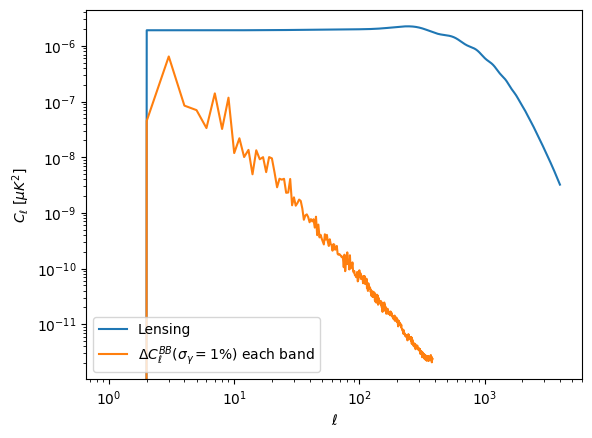

In [18]:
cl = sbm.load_fiducial_cl(r=0)

plt.loglog(cl[2], label="Lensing")
plt.loglog(cl_res[2], label=r"$\Delta C_\ell^{BB} (\sigma_\gamma=1\%)$ each band")
plt.xlabel("$\ell$")
plt.ylabel("$C_{\ell}$ [$\mu K^2$]")
plt.legend()

Δr =  2.648209437593624e-05


Text(0, 0.5, 'Likelihood')

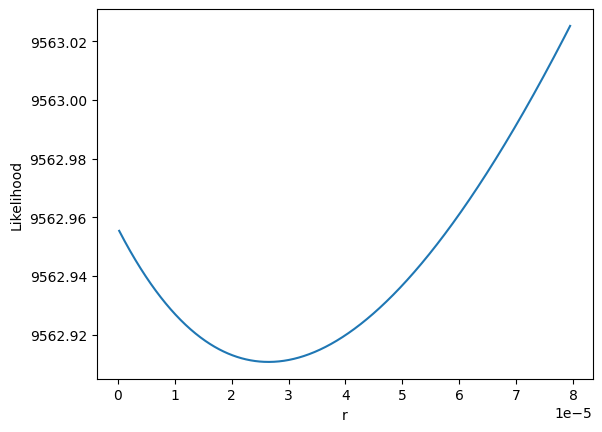

In [11]:
data = sbm.forecast(cl_res[2], fsky=0.6, lmax=191)
print("Δr = ", data["delta_r"])
plt.plot(data["grid_r"], data["likelihood"])
plt.xlabel("r")
plt.ylabel("Likelihood")